## Семинар 4: "Сверточные сети"

ФИО: Роор Даниил Дмитриевич

In [4]:
import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
from IPython.display import clear_output
%matplotlib inline

### Часть 1: Свертка

#### Одномерные сигналы
Начнем с одномерных сигналов — например, это могут быть различные временные ряды. 

<i>1.1 Реализуйте функцию, вычисляющую одномерную свертку.</i>

In [5]:
def t_convolve(signal, kernel):
    signal_convolved = np.zeros(len(signal)-len(kernel)+1)
    # 1. не забудьте перевернуть ядро!
    # 2. необходимо реализовать свертку без отступов, т.е. 
    #   размер результирующего сигнала должен быть меньше входного.
    
    half = len(kernel) // 2
    for i in range(half, signal.shape[0] - half):
        signal_convolved[i - half] = np.sum(kernel[::-1] * signal[i - half : i + half + 1])
        
    return signal_convolved

Проверим правильность реализации, сравнив с реализацией из scipy

In [6]:
from scipy.signal import convolve

signal = np.random.rand(100)
kernel = np.random.rand(5)
t_result = t_convolve(signal, kernel)
b_result = convolve(signal, kernel, mode='valid')

np.testing.assert_allclose(t_result, b_result)

Посмотрим как операция свертки может помочь нам убрать шум из сигнала

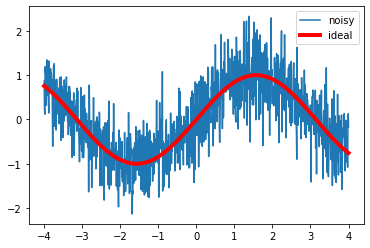

In [7]:
x = np.linspace(-4, 4, 1000)
signal = np.sin(x)
noisy_signal = signal + np.random.randn(signal.shape[0])*0.5
plt.plot(x, noisy_signal, label='noisy')
plt.plot(x, signal, 'r', label='ideal', linewidth=4)
plt.legend(loc=0)

Для подавления шума можно использовать усреднение значений сигнала в окрестности каждой точки (см. ЗБЧ). Вы можете убедиться, что такая операция может быть реализована при помощи свертки данных с ядром, $[\frac 1w, \frac 1w, ..., \frac 1w]$, где $w$ — размер окна.

<i>1.2  Вычислите свертку <b>зашумленного</b> сигнала с ядром $[0.2, 0.2, 0.2, 0.2, 0.2]$ </i>

In [11]:
kernel = np.array([0.2,0.2,0.2,0.2,0.2])

denoised_signal = convolve(noisy_signal, kernel, 'same')

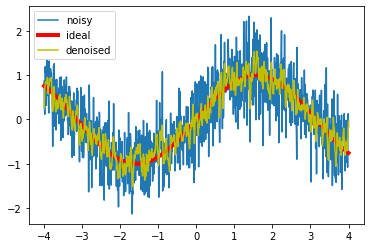

In [12]:
x = np.linspace(-4, 4, 1000)
plt.plot(x, noisy_signal, label='noisy')
plt.plot(x, signal, 'r', label='ideal', linewidth=4)
plt.plot(x, denoised_signal, 'y', label='denoised')
plt.legend(loc=0)

Заметим, что уровень шума значительно снизился! Попробуйте подобрать такую ширину окна, чтобы востановленный сигнал был наиболее похож на исходный.

<i> 1.3 Подберите размер окна <i>

In [14]:
optim_size, min_mse = 0, 100000000000000000000000000000000000000000000000000000

for size in range(3, 999, 2):
    kernel = np.ones(size)
    kernel /= kernel.shape[0]

    denoised_signal = convolve(noisy_signal, kernel, 'same')    
    mse = ((signal - denoised_signal)**2).mean()
    
    if mse < min_mse:
        min_mse = mse
        optim_size = size
    
    print("Kernel size: {}, MSE = {}".format(size, mse))
    
print('Optimal size: {}'.format(optim_size))

Kernel size: 3, MSE = 0.0868536032756855
Kernel size: 5, MSE = 0.04821314418379661
Kernel size: 7, MSE = 0.032982796750983666
Kernel size: 9, MSE = 0.02478305116352278
Kernel size: 11, MSE = 0.020214059757381653
Kernel size: 13, MSE = 0.0170919383861652
Kernel size: 15, MSE = 0.015210355694527701
Kernel size: 17, MSE = 0.013655175148778651
Kernel size: 19, MSE = 0.012501010322305963
Kernel size: 21, MSE = 0.011633392062446964
Kernel size: 23, MSE = 0.010994424760220433
Kernel size: 25, MSE = 0.010446208769368276
Kernel size: 27, MSE = 0.009987757834367266
Kernel size: 29, MSE = 0.009599923830702932
Kernel size: 31, MSE = 0.009269011789086765
Kernel size: 33, MSE = 0.00896359300527646
Kernel size: 35, MSE = 0.008750366867203525
Kernel size: 37, MSE = 0.008570312122233558
Kernel size: 39, MSE = 0.008395762310593583
Kernel size: 41, MSE = 0.008230714625522575
Kernel size: 43, MSE = 0.00808878465702401
Kernel size: 45, MSE = 0.00798749498524743
Kernel size: 47, MSE = 0.007924159696636195
K

Kernel size: 559, MSE = 0.2343064920089022
Kernel size: 561, MSE = 0.23594718236271467
Kernel size: 563, MSE = 0.2375854967139473
Kernel size: 565, MSE = 0.2392306110938488
Kernel size: 567, MSE = 0.24087398304120036
Kernel size: 569, MSE = 0.2425205983960314
Kernel size: 571, MSE = 0.24416733776483399
Kernel size: 573, MSE = 0.24581383233637571
Kernel size: 575, MSE = 0.24745904188133427
Kernel size: 577, MSE = 0.24910621344264489
Kernel size: 579, MSE = 0.2507547293977097
Kernel size: 581, MSE = 0.25240200779559874
Kernel size: 583, MSE = 0.2540447803433251
Kernel size: 585, MSE = 0.2556823842865217
Kernel size: 587, MSE = 0.2573189629255047
Kernel size: 589, MSE = 0.25895691574866164
Kernel size: 591, MSE = 0.26059696523560466
Kernel size: 593, MSE = 0.26223439527059866
Kernel size: 595, MSE = 0.2638689447439945
Kernel size: 597, MSE = 0.26550178091181714
Kernel size: 599, MSE = 0.2671343471126509
Kernel size: 601, MSE = 0.26876431730060124
Kernel size: 603, MSE = 0.2703920061903432

#### Многомерные сигналы
Перейдем теперь к черно-белым и цветным изображениям. Для ЧБ изображений имеем двумерный сигнал, для цветных — трехмерный (высота x ширина x каналы).

Для цветных изображений количество каналов ядра обычно совпадает с количеством каналов изображения. Таким образом, в результате получается черно-белое изображение.

<i>Для вычисления многомерных сверток используйте функцию convolve из from scipy.signal import convolve</i>

In [25]:
image = plt.imread('image.jpg')

In [26]:
image.shape

(666, 1000, 3)

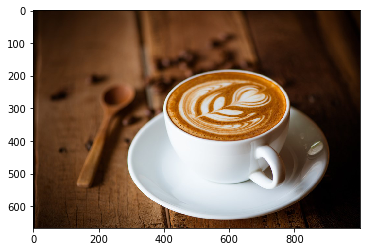

In [27]:
plt.imshow(image.astype('int'))

<i>1.4 Найдите в вашей любимой поисковой системе веса каналов для перевода цветного изображения в черно-белое. Постройте фильтр, который будет переводить цветное изображение в ЧБ</i>

In [53]:
from scipy.signal import convolve

def rgb_to_bw(image):
    color_to_bw = np.array([0.2989, 0.5870, 0.1140]).reshape(1, 1, 3)
    bw_image = convolve(image, color_to_bw, 'same')
    w, h = bw_image.shape[1], bw_image.shape[0]
    bw_image = bw_image[:,:,1]
    bw_image = bw_image.reshape(h, w)
    return bw_image

<i>1.5 На примере любого цветного изображения покажите результат его свертки с фильтром из предыдущего задания.</i>

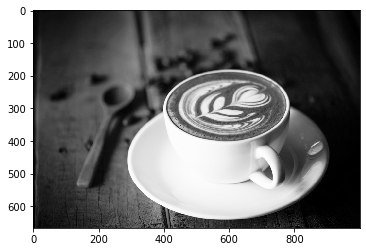

In [55]:
bw_image = rgb_to_bw(image)
plt.imshow(bw_image, cmap=plt.cm.Greys_r)

Операция свертки также позволяет находить границы на изображении. Для этого можно использовать, например, фильтр Собеля.

<i>1.6 Задайте ядро <a href="https://ru.wikipedia.org/wiki/Оператор_Собеля">фильтра Собеля</a> и продемонстрируйте результат его применения к любому цветному изображению.</i>

In [56]:
from scipy.signal import convolve2d

kernel = np.array([[-1, -2, -1],
                   [0,   0,  0],
                   [+1, +2, +1]])

res_y = convolve2d(bw_image, kernel.T, 'same')
res_x = convolve2d(bw_image, kernel, 'same')

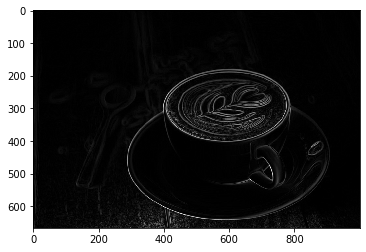

In [57]:
plt.imshow((res_x**2 + res_y**2)**0.5, cmap=plt.cm.Greys_r)

В сверточных нейронных сетях каждый слой использует несколько фильтров. Допустим, у нас было изображение с тремя каналами (количество входных каналов). Рассмотрим банк из четырех фильтров (количество выходных каналов). Тогда изначально будет вычислена свертка с каждым фильтром — получим 4 ЧБ изображения. Теперь соединим их в одно, интерпретируя каждое ЧБ изображение как канал цветного: RGB$\alpha$.

<i>1.7 Реализуйте операцию свертки с банком фильтров (filter bank).</i>

In [58]:
#kernel_shape = [n_kernels, x, y, n_channels]

def t_convolve_bank(signal, kernel):
    assert signal.ndim == kernel.ndim - 1

    result = np.zeros(signal.shape[:-1] + (kernel.shape[0],), dtype=int)
    
    for i in range(kernel.shape[0]):
        result[:, :, i] = convolve(signal, kernel[i, :, :, :], 'valid')[:, :, 0]
        print(signal[0, 0, :])
        print(result[0, 0, i])

    return result

<i>1.8 Задайте банк фильтров, меняющий порядок следования каналов с RGB на BGR.</i>

In [59]:
#RGB -> RBG

kernels = np.zeros((3, 1, 1, 3))

kernels[0, 0, 0, 0] = 1
kernels[1, 0, 0, 0] = 1

kernels[2, 0, 0, 1] = 1

kernels[1, 0, 0, 2] = 1
kernels[2, 0, 0, 2] = 1

<i>1.9 Продемонстрируйте результат свертки любого цветного изображения с банком фильтров из предыдущего пункта.</i>

[14.  6.  3.]
3
[14.  6.  3.]
17
[14.  6.  3.]
20


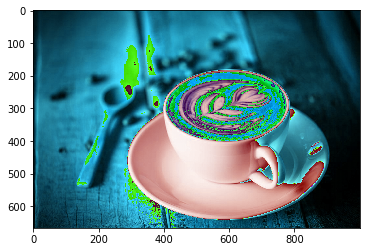

In [60]:
res_image = t_convolve_bank(image.astype(float), kernels)

plt.imshow(res_image.astype('uint8'))

# Не забудьте, что после свертки вы скорее всего получите тензор типа float. 
# Чтобы imshow нормально отобразил результат, надо привести его к типу uint8 (нпр., при помощи .astype('uint8'))

В процессе обучения сверточных нейронных сетей настраиваются веса элементов фильтр банка. Это позволяет не заниматься подбором коэффициентов "руками", а задавать лишь размер ядра: ширину, высоту, количество входных и выходных каналов. В итоге получаем четырехмерный массив (тензор).

### Часть 2: Пулинг

При использовании сверточных слоев принято использовать слои пулинга. Эта операция позволяет уменьшить пространственные размерности изображения и избавиться от избыточности.

<i>2.1 Реализуйте операции пулинга для цветных изображений</i>

In [61]:
def maxpool(image, w=2):
    assert(image.ndim == 3)
    
    res = np.zeros((image.shape[0] // w, image.shape[1] // w, image.shape[2]))
    for i in range(0, image.shape[0], w):
        for j in range(0, image.shape[1], w):
            for k in range(image.shape[2]):
                res[i//w, j//w, k] = np.max(image[i:i+w, j:j+w, k])
                
    return res
    

def medianpool(image, w=2):
    assert(image.ndim == 3)
    
    res = np.zeros((image.shape[0] // w, image.shape[1] // w, image.shape[2]))
    for i in range(0, image.shape[0], w):
        for j in range(0, image.shape[1], w):
            for k in range(image.shape[2]):
                res[i//w, j//w, k] = np.median(image[i:i+w, j:j+w, k])
                
    return res

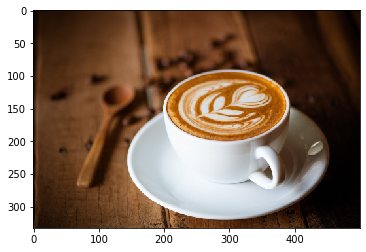

In [62]:
res_image = maxpool(image.astype(float))
plt.imshow(res_image.astype('uint8'))

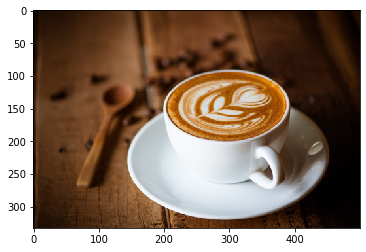

In [64]:
res_image = medianpool(image.astype(float))
plt.imshow(res_image.astype('uint8'))

Уменьшилась размерность, изображение стало "более квадратным", нечетким

Как и в первой части, посмотрим сначала как эта опреация влияет на цветные изображения.

<i>2.2 Взять цветное изображение и добавить к нему <a href="https://ru.wikipedia.org/wiki/Salt_and_pepper"> шум соль и перец</a>. Применить медианный пулинг и максимальный пулинг.</i>

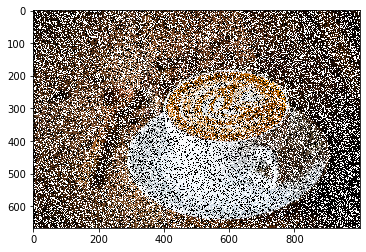

In [65]:
frac = 0.7

res_image = np.array(image)

ind = np.random.rand(*image.shape[:2]) > frac
res_image[ind, :] = 0

ind = np.random.rand(*image.shape[:2]) > frac
res_image[ind, :] = 255

plt.imshow(res_image.astype('uint8'))

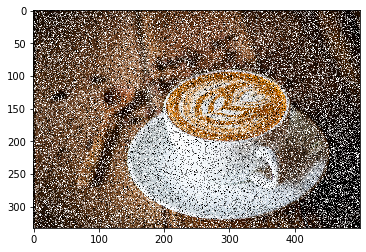

In [68]:
clean_image = medianpool(res_image.astype(float))

plt.imshow(clean_image.astype('uint8'))

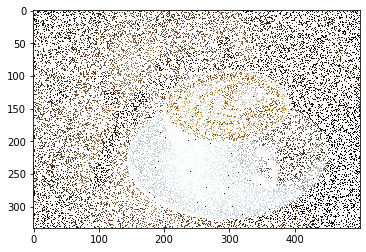

In [69]:
clean_image = maxpool(res_image.astype(float))

plt.imshow(clean_image.astype('uint8'))

<i>2.3 Какой тип пулинга лучше справился с поставленной задачей? Почему?</i>

Medianpool, так как усреднение сглаживает резкие перепады значений пикселей.

### Часть 3: Сверточная сеть на pyTorch

pyTorch предоставляет модули свертки и пулинга. Попробуем построить сеть и натренировать ее на данных MNIST. Для загрузки данных воспользуйтесь кодом со второго семинара.

Воспользуемся кодом с предыдущего семинара, чтобы обучить сверточную сеть на данных MNIST. Попробуем две архитектуры: 
2. input -> 8 Conv 3x3 -> ReLU -> maxpool -> 16 Conv 3x3 -> ReLU -> ravel -> Linear -> LogSoftmax
1. input -> 8 Conv 3x3 -> ReLU -> 16 Conv 3x3 -> ReLU -> maxpool -> 32 Conv 3x3 -> ravel -> Linear -> LogSoftmax

Здесь запись "c conv KxK" означает то, что на выходе должно получиться c каналов, а размер ядра — KxK

Ниже приведен пример сети. <i>(Документация: http://pytorch.org/docs/)</i>

In [70]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...


/home/danroor/anaconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


In [74]:
# пример сверточной сети

image_size = 28
channels = 1
class ConvClassifier(nn.Module):
    def __init__(self, image_size):
        super(ConvClassifier, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(channels, 3, 3, padding=1), 
            nn.ReLU(), 
            nn.MaxPool2d(2))
        self.linear_layers = nn.Sequential(
            nn.Linear(image_size // 2 * image_size // 2 * 3, 10), 
            nn.LogSoftmax(dim=1))
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [75]:
def train(network, epochs, learning_rate):
    loss = nn.NLLLoss()
    optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                network.zero_grad()
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                loss_batch.backward()
                optimizer.step()
                accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []    
            for X, y in test_loader:
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            print('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                        train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.plot(train_loss_epochs, label='Train')
            plt.plot(test_loss_epochs, label='Test')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.subplot(1, 2, 2)
            plt.plot(train_accuracy_epochs, label='Train accuracy')
            plt.plot(test_accuracy_epochs, label='Test accuracy')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.show()
    except KeyboardInterrupt:
        pass

Epoch 4... (Train/Test) NLL: 0.280/0.264	Accuracy: 0.918/0.924


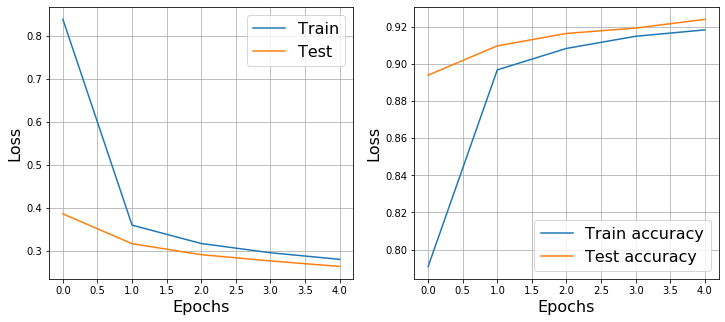

In [76]:
network = ConvClassifier(image_size=28)
train(network, 5, 1e-4)

<i>3.1 Обучите сверточные сети с архитектурами (1) и (2). Какое качество удалось получить на тестовой выборке? Какой результат получался на полносвязной нейронной сети?</i>

In [86]:
image_size = 28

# 2. input -> 8 Conv 3x3 -> ReLU -> maxpool -> 16 Conv 3x3 
# -> ReLU -> ravel -> Linear -> LogSoftmax

class ConvClassifier1(nn.Module):
    def __init__(self, image_size):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 8, 3, padding=1), 
            nn.ReLU(), 
            nn.MaxPool2d(2),
            nn.Conv2d(8, 16, 3, padding=1),
            nn.ReLU())
        self.linear_layers = nn.Sequential(
            nn.Linear(image_size // 2 * image_size // 2 * 16, 10), 
            nn.LogSoftmax(dim=1))
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x
    
#  input -> 8 Conv 3x3 -> ReLU -> 16 Conv 3x3 -> ReLU -> maxpool 
# -> 32 Conv 3x3 -> ravel -> Linear -> LogSoftmax

class ConvClassifier2(nn.Module):
    def __init__(self, image_size):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 8, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1))
        self.linear_layers = nn.Sequential(
            nn.Linear(image_size // 2 * image_size // 2 * 32, 10),
            nn.LogSoftmax(dim=1))
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

Epoch 4... (Train/Test) NLL: 0.084/0.068	Accuracy: 0.976/0.979


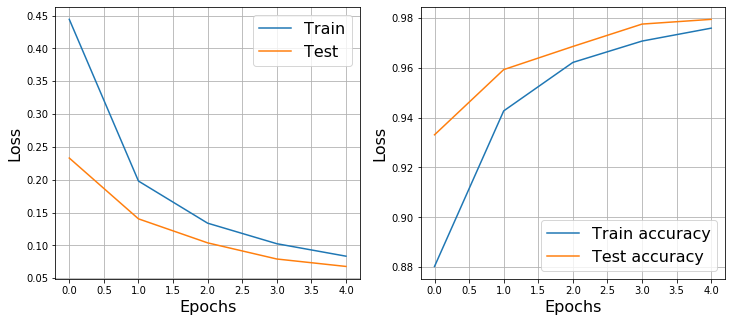

In [89]:
network1 = ConvClassifier1(image_size=28)
train(network1, 5, 1e-4)

Epoch 4... (Train/Test) NLL: 0.064/0.057	Accuracy: 0.981/0.983


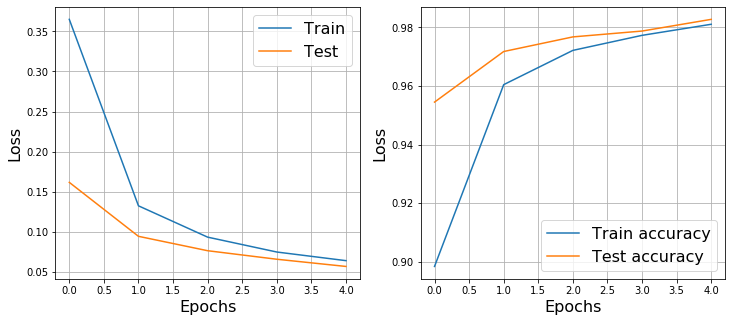

In [90]:
network2 = ConvClassifier2(image_size=28)
train(network2, 5, 1e-4)

Архитектуры 1 и 2 дали результаты по Accuracy 0.976/0.979 и 0.981/0.983.

Результаты полносвязной сети из домашнего задания 2: 0.991/0.977 (ReLU), 0.986/0.976 (ELU), 0.994/0.975 (TanH)

В целом результат изменился не сильно. Отметим только, что архитектура 2 превзошла все полносвязные сети на тесте.

<i>3.2 На каких объектах сеть ошибается сильнее всего? Нарисуйте эти объекты с правильными и предсказаными метками.</i>

In [92]:
wrong_X = []
correct_y = []
predicted_y = []
logits = []
for X, y in test_loader:
    prediction = network.forward(X).detach().numpy()
    prediction = np.exp(prediction)
    prediction /= prediction.sum(1, keepdims=True)
    for i in range(len(prediction)):
        if np.argmax(prediction[i]) != y[i]:
            wrong_X.append(X[i])
            correct_y.append(y[i])
            predicted_y.append(np.argmax(prediction[i]))
            logits.append(prediction[i][y[i]])
wrong_X = np.row_stack(wrong_X)
correct_y = np.row_stack(correct_y)[:, 0]
predicted_y = np.row_stack(predicted_y)[:, 0]
logits = np.row_stack(logits)[:, 0]

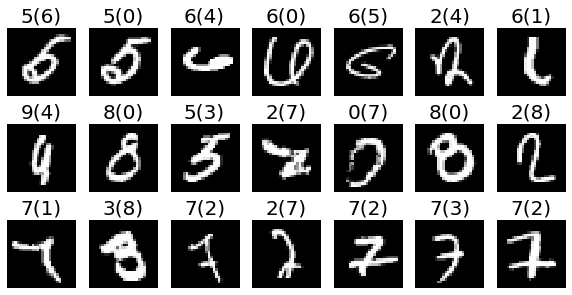

In [93]:
plt.figure(figsize=(10, 5))
order = np.argsort(logits)
for i in range(21):
    plt.subplot(3, 7, i+1)
    plt.imshow(wrong_X[order[i]].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title('{}({})'.format(correct_y[order[i]], predicted_y[order[i]]), fontsize=20)
    plt.axis('off')

<i>3.3 Поэкспериментируйте с различными архитектурами сверточных сетей. Смогли ли вы улучшить результат на тестовой выборке?</i>

In [96]:
class ConvClassifier3(nn.Module):
    def __init__(self, image_size):
        super(ConvClassifier3, self).__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(1, 24, 5, padding=2),
                                         nn.ReLU(),
                                         nn.MaxPool2d(2),
                                         nn.Conv2d(24, 48, 5, padding=2),
                                         nn.ReLU(),
                                         nn.MaxPool2d(2),
                                         nn.Conv2d(48, 64, 5, padding=2),
                                         nn.ReLU(),
                                         nn.MaxPool2d(2))
                                    
        
        self.linear_layers = nn.Sequential(nn.Linear((image_size//8)*(image_size//8)*64, 256),
                                           nn.ReLU(), 
                                           nn.Linear(256, 10),
                                           nn.LogSoftmax(dim=1))
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

Epoch 4... (Train/Test) NLL: 0.019/0.023	Accuracy: 0.994/0.993


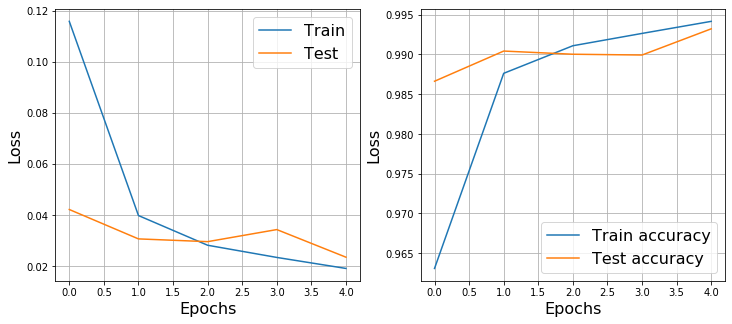

CPU times: user 13min 47s, sys: 3.6 s, total: 13min 51s
Wall time: 6min 57s


In [95]:
%%time
network3 = ConvClassifier3(image_size=28)
train(network3, 5, 1e-3)

Изменение размерностей сверток помогло улучшить результат.

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: